In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from tqdm import tqdm_notebook
import time

import torch
from torch import nn
from torch.nn import functional as F

In [3]:


train_data = pd.read_csv('train.tsv', sep='\t')
train_data.head()

,docid,rel,quid,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,...,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45
0,1,0,10,0.000000,0.000000,0.00,0.000000,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.017241,0.000000,0.000000,0.0
1,2,1,10,0.031310,0.666667,0.50,0.166667,0.033206,0.0,0.0,...,0.646890,0.686107,0.823908,0.750092,0.385426,0.923077,0.086207,0.333333,0.448276,0.0
2,3,1,10,0.078682,0.166667,0.50,0.333333,0.080022,0.0,0.0,...,0.649824,0.578581,0.868557,0.641385,0.010462,0.076923,0.074713,0.833333,0.678161,0.0
3,4,1,10,0.019058,1.000000,1.00,0.500000,0.022591,0.0,0.0,...,0.918403,0.868457,1.000000,0.863460,0.016642,0.153846,0.040230,0.833333,0.896552,0.0
4,5,0,10,0.039477,0.000000,0.75,0.166667,0.040555,0.0,0.0,...,0.565875,0.569440,0.769845,0.646567,0.073711,0.076923,0.034483,0.333333,0.218391,0.0


In [34]:
train_data.shape

(51562, 49)

In [6]:
test_data = pd.read_csv('test.tsv', sep='\t')
test_data.head()

,docid,quid,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,...,feature_36,feature_37,feature_38,feature_39,feature_40,feature_41,feature_42,feature_43,feature_44,feature_45
0,1,7968,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.00,0.0
1,2,7968,0.205882,0.0,0.0,0.0,0.205882,0.0,0.0,0.0,...,0.916516,0.686669,0.674704,0.708795,0.217889,0.272727,0.000000,0.333333,0.42,0.0
2,3,7968,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.031069,0.090909,0.092593,0.500000,0.68,0.0
3,4,7968,0.088235,0.0,0.0,0.0,0.088235,0.0,0.0,0.0,...,0.900721,0.789495,0.536695,0.789458,0.562992,0.045455,0.000000,0.666667,0.86,0.0
4,5,7968,0.558824,0.0,0.0,0.0,0.558824,0.0,0.0,0.0,...,0.557493,0.452582,0.660139,0.389950,0.120613,0.772727,0.000000,0.500000,0.46,0.0


In [33]:
test_data.shape

(33272, 48)

In [9]:
quids = train_data.quid.unique()
quids

array([   10,    15,    33, ..., 18211, 18214, 18218])

In [10]:
from sklearn.model_selection import train_test_split

train_quids, val_quids = train_test_split(quids, test_size=0.2)

In [12]:
def DCG(ranks, p=10):
    assert len(ranks) >= p
    return np.sum(ranks[:p] / np.log2(np.arange(2, p + 2, 1)))

def NDCG(ranks, p=10):
    dcg = DCG(ranks, p)
    idcg = DCG(sorted(ranks, reverse=True), p)
    
    return dcg / idcg

In [14]:
def listnet(true, pred):
    softmax_true = F.softmax(true, dim=-1)
    softmax_pred = F.softmax(pred, dim=-1)
    
    return -torch.sum(softmax_true * torch.log(softmax_pred))

In [17]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        dense1 = nn.Linear(46, 92)
        relu1 = nn.ReLU()
        dense2 = nn.Linear(92, 46)
        relu2 = nn.ReLU()
        dense3 = nn.Linear(46, 23)
        relu3 = nn.ReLU()
        dense4 = nn.Linear(23, 10)
        relu4 = nn.ReLU()
        dense5 = nn.Linear(10, 1)
        self.net = nn.Sequential(*[dense1, relu1, dense2, relu2,  dense3, relu3, dense4, relu4, dense5])
        
    def forward(self, X):
        y = self.net(X)
        return y.view(-1)

In [18]:
model = net()
model = model.cuda()

In [19]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [20]:
train_loss_history = []
train_metric_history = []
val_loss_history = []
val_metric_history = []

In [21]:
from tqdm import tqdm

Epoch 50 took 8.340704917907715 s


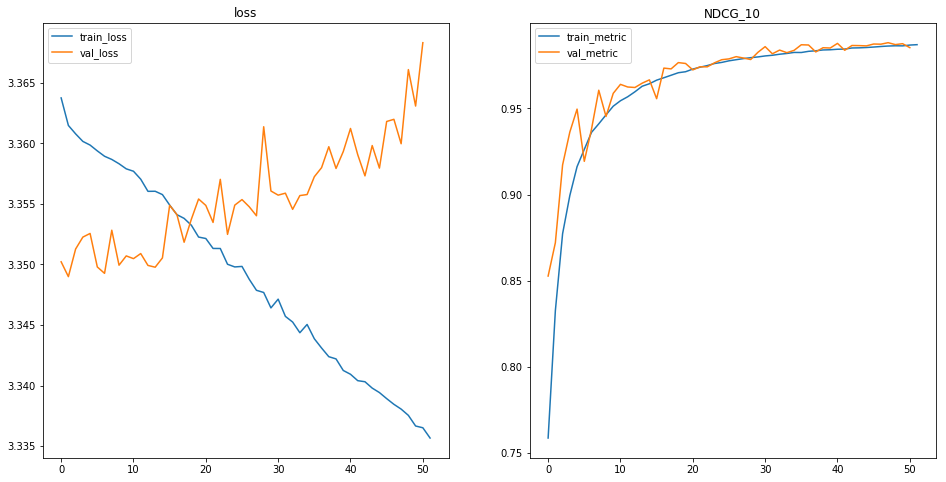

100%|██████████| 50/50 [07:08<00:00,  8.54s/it]


In [26]:
for n_epoch in tqdm(range(50)):
    model.train()
    np.random.shuffle(train_quids)
    start = time.time()
    cur_loss, cur_metric = 0, 0
    cnt = 0
    for quid in train_quids:
        tmp = train_data.groupby('quid').get_group(quid)
        y = torch.Tensor(tmp['rel'].values).cuda()
        X = torch.Tensor(tmp[tmp.columns.delete((0, 1, 2))].values).cuda()
        
        pred = model(X)
        loss = listnet(y, pred)
        loss.backward()
        cur_loss += loss.item()
        opt.step()
        opt.zero_grad()

        if len(pred) >= 10:
            cur_metric += NDCG(pred.detach().cpu().numpy())
            cnt += 1
    
    train_loss_history.append(cur_loss / len(train_quids))
    train_metric_history.append(cur_metric / cnt)
    
    model.eval()
    cur_loss, cur_metric = 0, 0 
    cnt = 0
    for quid in val_quids:
        tmp = train_data.groupby('quid').get_group(quid)
        y = torch.Tensor(tmp['rel'].values).cuda()
        X = torch.Tensor(tmp[tmp.columns.delete((0, 1, 2))].values).cuda()
        
        pred = model(X)
        cur_loss += listnet(y, pred).item()
        if len(pred) >= 10:
            cur_metric += NDCG(pred.detach().cpu().numpy())
            cnt += 1
        
    val_loss_history.append(cur_loss / len(val_quids))
    val_metric_history.append(cur_metric / cnt)
    
    display.clear_output()
    
    print('Epoch {} took {} s'.format(n_epoch + 1, time.time() - start))
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.plot(train_loss_history, label='train_loss')
    plt.plot(val_loss_history, label='val_loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('NDCG_10')
    plt.plot(train_metric_history, label='train_metric')
    plt.plot(val_metric_history, label='val_metric')
    plt.legend()
    plt.show()

In [27]:
sub = pd.read_csv('sample.csv')
sub.head()

,docid,quid
0,1,7968
1,2,7968
2,3,7968
3,4,7968
4,5,7968


In [29]:
model.eval()
with torch.no_grad():
    pred = model(torch.Tensor(test_data[test_data.columns.delete((0, 1))].values).cuda()).cpu().numpy()

In [30]:
pred.shape

(33272,)

In [35]:
sub.docid = test_data.docid
sub.quid = test_data.quid
sub['rank'] = pred
sub.head()

,docid,quid,rank
0,1,7968,26.385693
1,2,7968,26.777142
2,3,7968,26.502251
3,4,7968,26.572327
4,5,7968,26.846060


In [36]:
sub.sort_values(['quid', 'rank'], ascending=False, inplace=True)
sub.head()

,docid,quid,rank
33265,33266,19997,27.629963
33270,33271,19997,27.162045
33266,33267,19997,26.831520
33268,33269,19997,26.597721
33269,33270,19997,26.569139


In [37]:
sub.to_csv('my_sub.csv', index=False, columns=['docid', 'quid'])


попробуем другую сеть

In [38]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Dropout(0.1),
            nn.Linear(46, 92),
            nn.BatchNorm1d(92),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(92, 46),
            nn.BatchNorm1d(46),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(46, 23),
            nn.BatchNorm1d(23),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(23, 10),
            nn.BatchNorm1d(10),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(10, 1)
        ]
        self.net = nn.Sequential(*layers)
        
    def forward(self, X):
        y = self.net(X)
        return y.view(-1)

In [39]:
model = net()
model = model.cuda()

In [40]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [41]:
train_loss_history = []
train_metric_history = []
val_loss_history = []
val_metric_history = []

In [42]:
from tqdm import tqdm

Epoch 50 took 11.621330261230469 s


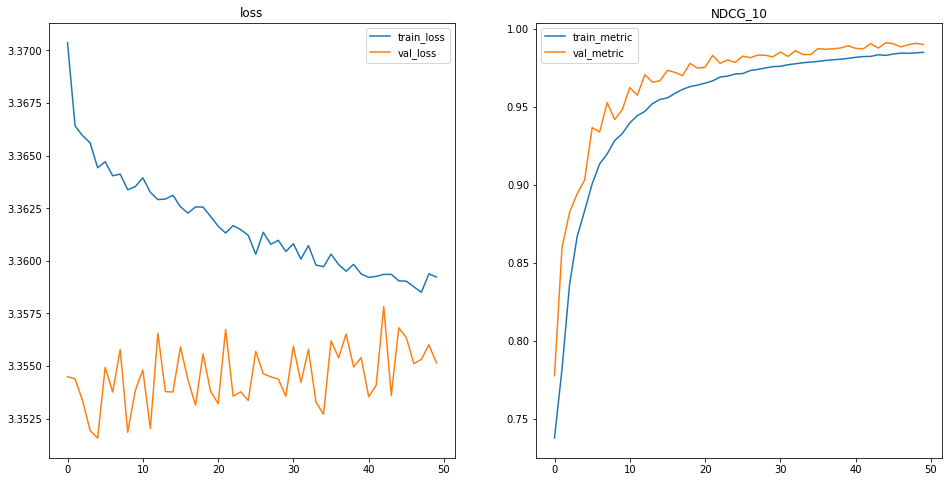

100%|██████████| 50/50 [09:49<00:00, 11.71s/it]


In [43]:
for n_epoch in tqdm(range(50)):
    model.train()
    np.random.shuffle(train_quids)
    start = time.time()
    cur_loss, cur_metric = 0, 0
    cnt = 0
    for quid in train_quids:
        tmp = train_data.groupby('quid').get_group(quid)
        y = torch.Tensor(tmp['rel'].values).cuda()
        X = torch.Tensor(tmp[tmp.columns.delete((0, 1, 2))].values).cuda()
        
        pred = model(X)
        loss = listnet(y, pred)
        loss.backward()
        cur_loss += loss.item()
        opt.step()
        opt.zero_grad()

        if len(pred) >= 10:
            cur_metric += NDCG(pred.detach().cpu().numpy())
            cnt += 1
    
    train_loss_history.append(cur_loss / len(train_quids))
    train_metric_history.append(cur_metric / cnt)
    
    model.eval()
    cur_loss, cur_metric = 0, 0 
    cnt = 0
    for quid in val_quids:
        tmp = train_data.groupby('quid').get_group(quid)
        y = torch.Tensor(tmp['rel'].values).cuda()
        X = torch.Tensor(tmp[tmp.columns.delete((0, 1, 2))].values).cuda()
        
        pred = model(X)
        cur_loss += listnet(y, pred).item()
        if len(pred) >= 10:
            cur_metric += NDCG(pred.detach().cpu().numpy())
            cnt += 1
        
    val_loss_history.append(cur_loss / len(val_quids))
    val_metric_history.append(cur_metric / cnt)
    
    display.clear_output()
    
    print('Epoch {} took {} s'.format(n_epoch + 1, time.time() - start))
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.plot(train_loss_history, label='train_loss')
    plt.plot(val_loss_history, label='val_loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('NDCG_10')
    plt.plot(train_metric_history, label='train_metric')
    plt.plot(val_metric_history, label='val_metric')
    plt.legend()
    plt.show()

In [44]:
model.eval()
with torch.no_grad():
    pred = model(torch.Tensor(test_data[test_data.columns.delete((0, 1))].values).cuda()).cpu().numpy()

In [45]:
pred.shape

(33272,)

In [46]:
sub.docid = test_data.docid
sub.quid = test_data.quid
sub['rank'] = pred
sub.head()

,docid,quid,rank
33265,33266,19997,17.212793
33270,33271,19997,17.448172
33266,33267,19997,17.181961
33268,33269,19997,17.365171
33269,33270,19997,17.423561


In [47]:
sub.sort_values(['quid', 'rank'], ascending=False, inplace=True)
sub.head()

,docid,quid,rank
33267,33268,19997,17.468311
33270,33271,19997,17.448172
33269,33270,19997,17.423561
33268,33269,19997,17.365171
33271,33272,19997,17.301125


In [48]:
sub.to_csv('my_sub_2.csv', index=False, columns=['docid', 'quid'])

третья попытка

In [49]:
class net(nn.Module):
    def __init__(self):
        super().__init__()
        layers = [
            nn.Dropout(0.1),
            nn.Linear(46, 23),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(23, 10),
            nn.LeakyReLU(),
            nn.Dropout(0.2),
            nn.Linear(10, 5),
            nn.LeakyReLU(),
            nn.Dropout(0.1),
            nn.Linear(5, 1)
        ]
        self.net = nn.Sequential(*layers)
        
    def forward(self, X):
        y = self.net(X)
        return y.view(-1)

In [50]:
model = net()
model = model.cuda()

In [51]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [52]:
train_loss_history = []
train_metric_history = []
val_loss_history = []
val_metric_history = []

In [53]:
from tqdm import tqdm

Epoch 50 took 8.111164093017578 s


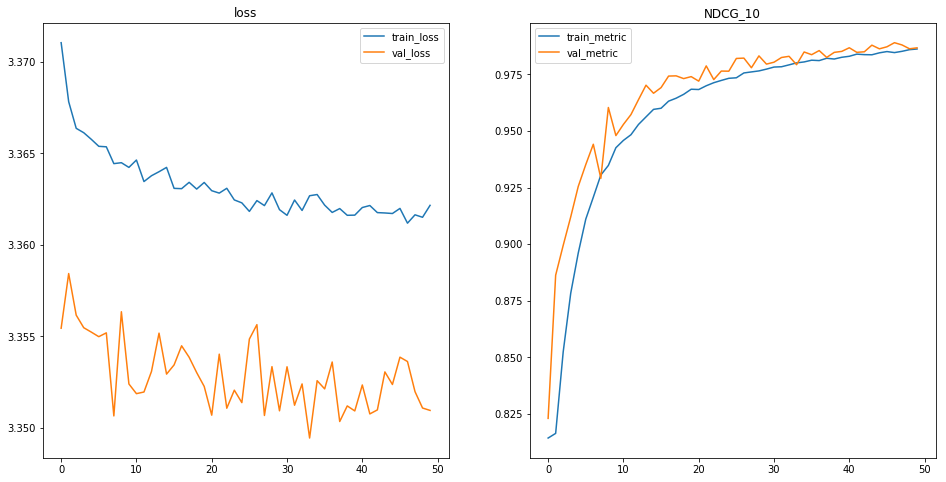

100%|██████████| 50/50 [06:57<00:00,  8.35s/it]


In [54]:
for n_epoch in tqdm(range(50)):
    model.train()
    np.random.shuffle(train_quids)
    start = time.time()
    cur_loss, cur_metric = 0, 0
    cnt = 0
    for quid in train_quids:
        tmp = train_data.groupby('quid').get_group(quid)
        y = torch.Tensor(tmp['rel'].values).cuda()
        X = torch.Tensor(tmp[tmp.columns.delete((0, 1, 2))].values).cuda()
        
        pred = model(X)
        loss = listnet(y, pred)
        loss.backward()
        cur_loss += loss.item()
        opt.step()
        opt.zero_grad()

        if len(pred) >= 10:
            cur_metric += NDCG(pred.detach().cpu().numpy())
            cnt += 1
    
    train_loss_history.append(cur_loss / len(train_quids))
    train_metric_history.append(cur_metric / cnt)
    
    model.eval()
    cur_loss, cur_metric = 0, 0 
    cnt = 0
    for quid in val_quids:
        tmp = train_data.groupby('quid').get_group(quid)
        y = torch.Tensor(tmp['rel'].values).cuda()
        X = torch.Tensor(tmp[tmp.columns.delete((0, 1, 2))].values).cuda()
        
        pred = model(X)
        cur_loss += listnet(y, pred).item()
        if len(pred) >= 10:
            cur_metric += NDCG(pred.detach().cpu().numpy())
            cnt += 1
        
    val_loss_history.append(cur_loss / len(val_quids))
    val_metric_history.append(cur_metric / cnt)
    
    display.clear_output()
    
    print('Epoch {} took {} s'.format(n_epoch + 1, time.time() - start))
    
    plt.figure(figsize=(16, 8))
    
    plt.subplot(1, 2, 1)
    plt.title('loss')
    plt.plot(train_loss_history, label='train_loss')
    plt.plot(val_loss_history, label='val_loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.title('NDCG_10')
    plt.plot(train_metric_history, label='train_metric')
    plt.plot(val_metric_history, label='val_metric')
    plt.legend()
    plt.show()

In [55]:
model.eval()
with torch.no_grad():
    pred = model(torch.Tensor(test_data[test_data.columns.delete((0, 1))].values).cuda()).cpu().numpy()

In [56]:
pred.shape

(33272,)

In [57]:
sub.docid = test_data.docid
sub.quid = test_data.quid
sub['rank'] = pred
sub.head()

,docid,quid,rank
33267,33268,19997,16.998421
33270,33271,19997,17.305784
33269,33270,19997,17.044573
33268,33269,19997,17.264500
33271,33272,19997,17.284092


In [58]:
sub.sort_values(['quid', 'rank'], ascending=False, inplace=True)
sub.head()

,docid,quid,rank
33270,33271,19997,17.305784
33266,33267,19997,17.294527
33271,33272,19997,17.284092
33268,33269,19997,17.264500
33265,33266,19997,17.149933


In [59]:
sub.to_csv('my_sub_3.csv', index=False, columns=['docid', 'quid'])